# UCSD Micromasters: Python for Data Science
Prepared by: Samuel Quiroga, May 2020

# Week 6 Mini Project - Analysis of Soccer Dataset

## Project Description

This report was prepared for the University of California San Diego MicroMasters Pogram course _Python for Data Science_. The goal of the project is to get an uderstanding of data science analysis in Python. For this project the Soccer Dataset was used.

## Research Question

Do soccer player's performance attributes get better or worse over time? For the top 10th percentile performers? bottom 10th percentile performers? And 50% percentile of performers?

## Executive Summary

In this report we analysed the `attributes` and `players` tables of the soccer data set. The data was cleaned by removing any null values and removing players with less than 33 sample points (for consistent plotting). The time period of the analysis spanned around 9 years (2007-2016).

We divided the data into quantiles based on players' performance (using the player's median of `overall_performance`) so that players with similar performance were plotted together. 

Plots of the players' attributes over time indicate that some players' attributes (such  as ball control and passing) do increase over time. While others remain constant or even go down (such as penalties and aggression). Further work should be done to cluster the data (e.g. k-means) to undertand and classify different types of players.

In [118]:
# Import appropiate libraries
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import pandas as pd 
import seaborn as sns
%matplotlib inline

## Data Loading

Data source: https://www.kaggle.com/hugomathien/soccer.

We'll select some desired attributes from the `attributes` table. Here we are selecting a small sample of player attributes to analyse: `overall_rating`, `long_passing`, `short_passing`, `ball_control`, `free_kick_accuracy`, `penalties`, and `aggression`.

In [119]:
# set connection to database
cnx = sqlite3.connect("./soccer/database.sqlite") 
# pull selected attributes
attributes = pd.read_sql_query("SELECT `player_api_id`,`date`,`overall_rating`,`long_passing`,\
`short_passing`,`ball_control`,`free_kick_accuracy`,`penalties`,`aggression` FROM Player_Attributes", cnx)
# pull Players
players = pd.read_sql_query("SELECT `player_api_id`,`player_name` FROM Player", cnx) 

We'l start by sampling some rows from the `attributes` table.

In [120]:
attributes.sample(n=10) # look at a random sample of 10 players

,player_api_id,date,overall_rating,long_passing,short_passing,ball_control,free_kick_accuracy,penalties,aggression
73799,264885,2013-02-22 00:00:00,63.0,54.0,52.0,57.0,31.0,28.0,74.0
26779,46890,2012-08-31 00:00:00,61.0,61.0,63.0,67.0,68.0,39.0,69.0
132801,25499,2009-08-30 00:00:00,77.0,53.0,74.0,77.0,67.0,82.0,74.0
12975,23022,2015-01-16 00:00:00,58.0,49.0,54.0,63.0,71.0,54.0,62.0
24870,131117,2010-02-22 00:00:00,58.0,26.0,33.0,28.0,13.0,13.0,54.0
44533,268283,2013-05-03 00:00:00,63.0,49.0,58.0,67.0,39.0,51.0,49.0
13982,27702,2015-09-21 00:00:00,72.0,76.0,74.0,73.0,74.0,66.0,74.0
22933,36835,2014-02-07 00:00:00,66.0,33.0,33.0,26.0,13.0,26.0,27.0
16675,107502,2014-10-02 00:00:00,63.0,68.0,69.0,67.0,64.0,60.0,49.0
145473,213317,2013-11-29 00:00:00,74.0,67.0,71.0,73.0,58.0,59.0,64.0


In [121]:
attributes.dtypes

player_api_id           int64
date                   object
overall_rating        float64
long_passing          float64
short_passing         float64
ball_control          float64
free_kick_accuracy    float64
penalties             float64
aggression            float64
dtype: object

You can see that the `date` column is not parsed in time. Let's change that to date_time:

In [122]:
attributes['date'] = pd.to_datetime(attributes.date)

Now, look at a sample of 10 players in the  `players` table. Here we are selecting the `player_api_id` and `player_name`.

In [123]:
players.sample(n=10)

,player_api_id,player_name
719,33792,Andreas Hinkel
9562,89079,Sebastian Eriksson
4876,619297,Jeroen van der Lely
3610,50373,Gabriel Gomez
10327,24230,Titus Bramble
1127,206830,Bartlomiej Pawlowski
9949,132829,Stephane Garcia
3956,30445,Grafite
2299,31993,Darryl Duffy
9303,164227,Rui Sampaio


## Data Cleaning

Let's determine how many of the rows have null values in the `attribute` table.

In [124]:
attributes.isnull().sum(axis = 0)

player_api_id           0
date                    0
overall_rating        836
long_passing          836
short_passing         836
ball_control          836
free_kick_accuracy    836
penalties             836
aggression            836
dtype: int64

We can see that we have 836 `null` values in every column except for the `player_api_id` and `date`. Let's remove those `null` values from the `attributes` table and check again for `null` values.

In [125]:
attributes = attributes.dropna()
attributes.isnull().any()

player_api_id         False
date                  False
overall_rating        False
long_passing          False
short_passing         False
ball_control          False
free_kick_accuracy    False
penalties             False
aggression            False
dtype: bool

Great, we can see we no longer have any `null` values. Now let's check the `players` table.

In [126]:
players.isnull().any().any()

False

Great! There are no `null` values in the `players` table.

## Data Exploration

Let's explore the `attributes` table a little more. First let's look at some descriptive statistics, including the 10th,25th, 50th, 75th and 90th percentile for attributes

In [127]:
# here we are selecting all columns while excluding the player_api_id, extract the description and then transpose
attributes.loc[:,attributes.columns != 'player_api_id'].\
    describe(percentiles=[0.1,0.25,0.5,0.75,0.9]).transpose()

,count,mean,std,min,10%,25%,50%,75%,90%,max
overall_rating,183142.0,68.600015,7.041139,33.0,60.0,64.0,69.0,73.0,77.0,94.0
long_passing,183142.0,57.069880,14.394464,3.0,36.0,49.0,59.0,67.0,74.0,97.0
short_passing,183142.0,62.429672,14.194068,3.0,42.0,57.0,65.0,72.0,77.0,97.0
ball_control,183142.0,63.388879,15.196671,5.0,43.0,58.0,67.0,73.0,78.0,97.0
free_kick_accuracy,183142.0,49.380950,17.831746,1.0,25.0,36.0,50.0,63.0,72.0,97.0
penalties,183142.0,55.003986,15.546519,2.0,33.0,45.0,57.0,67.0,74.0,96.0
aggression,183142.0,60.948046,16.089521,6.0,37.0,51.0,64.0,73.0,79.0,97.0


We can see that players in the 10th, 50th, and 90th percentile have an `overall_rating` of **60, 69 and 77** respectively. How many players are in this data set?

In [128]:
attributes.player_api_id.nunique() # total number of players

11060

We can see that there are just over 11,000 players in this dataset! What is the time span of the dataset?

In [129]:
print('Minimum date:',attributes.date.min())
print('Maximum date:',attributes.date.max())

Minimum date: 2007-02-22 00:00:00
Maximum date: 2016-07-07 00:00:00


The dataset spans a period of around 9 years. 

To get a sense of how many samples there are for each player, let's count the number of rows that each player has and look at the distribution. Here, we first group by player id, then compute the median (of the `overall_performance`) and count (of each row).

In [130]:
counts = attributes[['player_api_id','overall_rating']].\
    groupby(['player_api_id']).agg(['median','count']).reset_index() # group by player id and count rows.

counts.head() # get the first few samples

player_api_id overall_rating      
                        median count
0          2625           60.5    14
1          2752           70.0    21
2          2768           72.0    21
3          2770           71.0    15
4          2790           71.0     5

The output above gave us a table with a nested index which is not necessary for our analysis. So we'll remove it below:

In [131]:
counts.columns = counts.columns.droplevel(1)
counts.columns = ["player_api_id","median_overall_rating","count"]
counts.head()

,player_api_id,median_overall_rating,count
0,2625,60.5,14
1,2752,70.0,21
2,2768,72.0,21
3,2770,71.0,15
4,2790,71.0,5


Now let's look at some statistics of the count of the `overall_rating` attibute:

In [132]:
counts.drop('player_api_id',axis=1).describe(percentiles=[0.1,0.5,0.9,0.95]).transpose() # look at some statistics of the count

,count,mean,std,min,10%,50%,90%,95%,max
median_overall_rating,11060.0,67.162703,6.455990,41.0,59.0,67.0,75.0,78.0,93.0
count,11060.0,16.558951,9.361642,2.0,5.0,16.0,29.0,33.0,56.0


We see that **95% of the players have 33 data sample points or less** - so we can filter the counts for only players that have a large amount of data points (33 samples or more) in order to get a more reliable trend over time.

## Data Wrangling

First, let's merge the `counts` table with the `attributes` table.

In [133]:
new_attributes = attributes.merge(counts,how='left',on='player_api_id').\
    merge(players,how='left',on='player_api_id') # merge with attributes and players table
new_attributes.shape

(183142, 12)

Now we can filter for players that have at least 33 data points.

In [134]:
new_attributes = new_attributes[new_attributes["count"]>=33]
new_attributes.shape

(22614, 12)

Notice how much data have removed after filtering for players that have at least 33 data points. We went from over 183,000 rows to just over 22,600!

We can now get a subset of the best, worst, and mid performers that we can analyse. We saw above that players in the 10th, 50th, and 90th percentile have an `overall_rating` of **60, 69 and 77** respectively. So let's filter players median overall performance (`overall_rating`) based on these numbers. 

In [135]:
# get subset dataframes based on median overall rating
percentile_10 = new_attributes[new_attributes["median_overall_rating"]==60]
percentile_50 = new_attributes[new_attributes["median_overall_rating"]==69]
percentile_90 = new_attributes[new_attributes["median_overall_rating"]==77]

# print out number of players on each
print('Number of players in the 10th percentile:',len(percentile_10.player_api_id.unique()))
print('Number of players in the 50th percentile:',len(percentile_50.player_api_id.unique()))
print('Number of players in the 90th percentile:',len(percentile_90.player_api_id.unique()))

Number of players in the 10th percentile: 2
Number of players in the 50th percentile: 33
Number of players in the 90th percentile: 32


## Data Plotting

We can see that there are **only two players in the 10th percentile, and over 30 players in the 50th and 90th percentile**. In order to make the plots cleaner and easier to analyse, we'll take a sample of 5 players in the 50th and 90th percentiles.

In [136]:
# get sample of 5 players in each
sample_players_50 = np.random.choice(percentile_50.player_api_id.unique(),size=5,replace=False)
sample_players_90 = np.random.choice(percentile_90.player_api_id.unique(),size=5,replace=False)

# filter attribute tables with each sample of players
percentile_50 = percentile_50[percentile_50.player_api_id.isin(sample_players_50)]
percentile_90 = percentile_90[percentile_90.player_api_id.isin(sample_players_90)]

# confirm number of players in each
print('Number of players in the 10th percentile:',len(percentile_10.player_api_id.unique()))
print('Number of players in the 50th percentile:',len(percentile_50.player_api_id.unique()))
print('Number of players in the 90th percentile:',len(percentile_90.player_api_id.unique()))

Number of players in the 10th percentile: 2
Number of players in the 50th percentile: 5
Number of players in the 90th percentile: 5


In order to make plots of the attributes versus time, we need to have the attribute names in one column called `Attribute` and the value of the attribute in another column called `Value`. This makes it easier to plot a facet grid of each percentile table. Here we use the `pandas.melt` function to convert the ables into **long** format.

In [137]:
# select id and value variables to met
my_id_variables = ['player_name','date'] 
my_value_variables = ['long_passing','short_passing','ball_control','free_kick_accuracy','penalties','aggression']

# melt into long format
percentile_10_long = pd.melt(percentile_10,id_vars=my_id_variables,\
                             value_vars=my_value_variables, var_name = 'attribute',value_name='value')
percentile_50_long = pd.melt(percentile_50,id_vars=my_id_variables,\
                             value_vars=my_value_variables, var_name = 'attribute',value_name='value')
percentile_90_long = pd.melt(percentile_90,id_vars=my_id_variables,\
                             value_vars=my_value_variables, var_name = 'attribute',value_name='value')

percentile_10_long.head() # take a look the first few rows

,player_name,date,attribute,value
0,Gary McSheffrey,2016-06-09,long_passing,53.0
1,Gary McSheffrey,2016-06-02,long_passing,53.0
2,Gary McSheffrey,2016-05-26,long_passing,53.0
3,Gary McSheffrey,2016-04-28,long_passing,53.0
4,Gary McSheffrey,2016-03-24,long_passing,53.0


Now we can plot the attributes of each player vs time. We'll plot each percentile separately so that the players can be compared more fairly. In this report we will use the `seaborn` package to plot the data (see https://seaborn.pydata.org/ for more info).

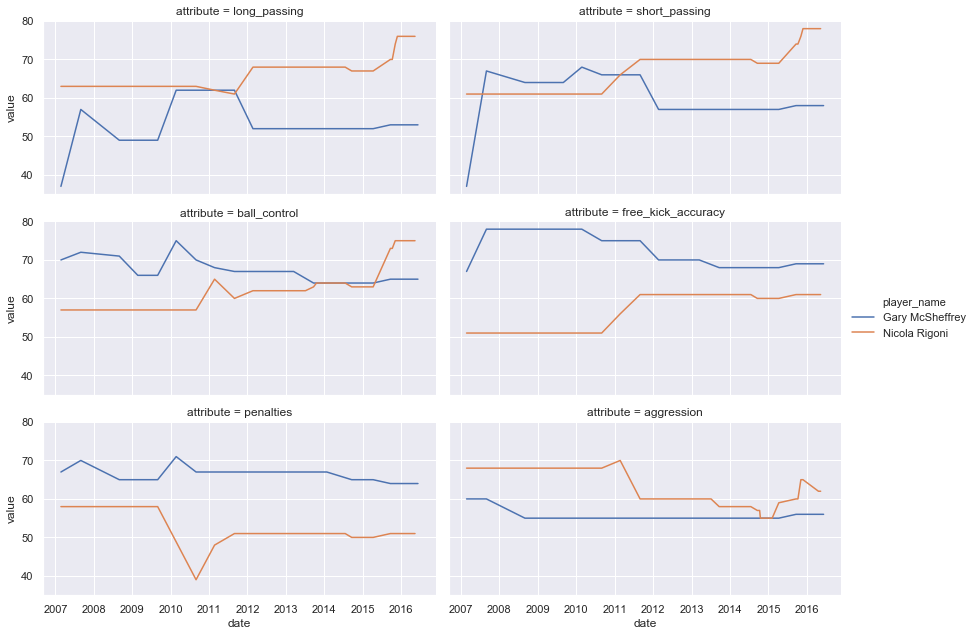

In [138]:
sns.set(style="darkgrid")

g = sns.relplot(x="date", y="value",
                hue="player_name", col="attribute",col_wrap=2,
                height=3, aspect=2,
                kind="line", data=percentile_10_long)

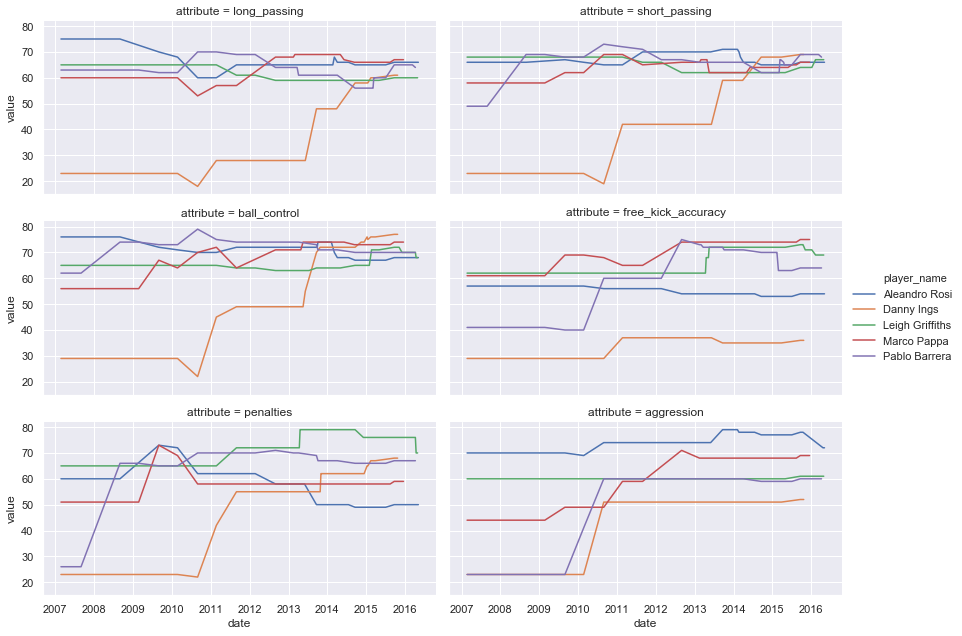

In [139]:
g = sns.relplot(x="date", y="value",
                hue="player_name", col="attribute",col_wrap=2,
                height=3, aspect=2,
                kind="line", data=percentile_50_long)

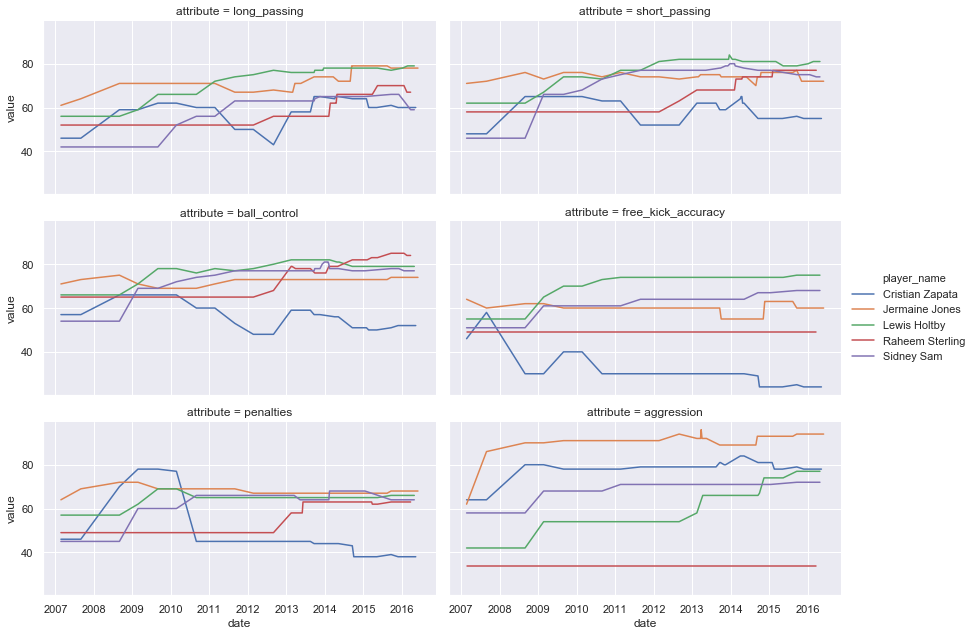

In [140]:
g = sns.relplot(x="date", y="value",
                hue="player_name", col="attribute",col_wrap=2,
                height=3, aspect=2,
                kind="line", data=percentile_90_long)

## Conclusion

We have done some exploratory data analysis of the soccer data set. In this report we wanted to see how certain player attributes vary over time. We have also separated the players by worst, medium and best performers based on the percentiles of the `overll_rating` attribute. 

The plots can help identify which players perform through out their careers and can also help identify players with greater potential.